# Time Series Forecasting with XGBoost
Advanced Demand Forecasting with Recursive and Ensemble Methods

In [300]:
!pip install skforecast

In [310]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from skforecast.recursive._forecaster_recursive import ForecasterRecursive
from sklearn.base import clone

## Data Loading
### Load and Clean the Dataset

In [311]:
# Load the historical demand dataset
df = pd.read_csv(r"historic_demand_2009_2024.csv", index_col=0)

# Remove columns with null values
# Note: These columns contain values that started appearing after a specific year
# and might be useful in future analyses
df.drop(columns=["nsl_flow", "eleclink_flow", "scottish_transfer", "viking_flow", "greenlink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48 (data quality issue)
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

# Select only the columns we need for this analysis
df = df[['settlement_date', 'settlement_period', 'tsd', 'is_holiday']]

# Remove days with zero demand (likely data quality issues)
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()
null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Display the cleaned dataset
print("\nCleaned dataset shape:", df.shape)
print("First 5 rows of cleaned data:")
print(df.head())


Cleaned dataset shape: (278512, 4)
First 5 rows of cleaned data:
  settlement_date  settlement_period    tsd  is_holiday
0      2009-01-01                  1  38704           1
1      2009-01-01                  2  38964           1
2      2009-01-01                  3  38651           1
3      2009-01-01                  4  37775           1
4      2009-01-01                  5  37298           1


## Feature Engineering
### Create Date-Time Features

In [313]:
def add_datepart(df):
    """
    Create comprehensive datetime features from the settlement date and period.

    Args:
        df (DataFrame): DataFrame containing settlement_date and settlement_period columns

    Returns:
        DataFrame: DataFrame with added datetime features
    """
    # Convert 'settlement_date' to datetime (ensure it's in the correct format)
    df["settlement_date"] = pd.to_datetime(df["settlement_date"])

    # Ensure that 'settlement_period' is an integer and calculate the period offset in minutes
    df["period_offset"] = pd.to_timedelta((df["settlement_period"] - 1) * 30, unit="m")

    # Add the period offset (Timedelta) to the settlement_date (Datetime) to get the timestamp
    df["timestamp"] = df["settlement_date"] + df["period_offset"]

    # Ensure 'timestamp' is in datetime format (in case it's not already)
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Create time-related features from timestamp
    df["day_of_week"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["month"] = df["timestamp"].dt.month
    df["quarter"] = df["timestamp"].dt.quarter
    df["is_month_end"] = df["timestamp"].dt.is_month_end.astype(int)
    df["is_month_start"] = df["timestamp"].dt.is_month_start.astype(int)
    df["is_quarter_end"] = df["timestamp"].dt.is_quarter_end.astype(int)
    df["is_quarter_start"] = df["timestamp"].dt.is_quarter_start.astype(int)
    df["is_year_end"] = df["timestamp"].dt.is_year_end.astype(int)
    df["is_year_start"] = df["timestamp"].dt.is_year_start.astype(int)
    df["day_of_year"] = df["timestamp"].dt.dayofyear
    df["week_of_year"] = df["timestamp"].dt.isocalendar().week.astype(int)
    df["hour"] = df["timestamp"].dt.hour
    df["minute"] = df["timestamp"].dt.minute
    return df


In [314]:


df = add_datepart(df)

# Clean up and set the timestamp as index
df.drop(columns=["period_offset", "settlement_date"], inplace=True)
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)



## Data Exploration and Visualization
Examine Dataset Correlations and Patterns

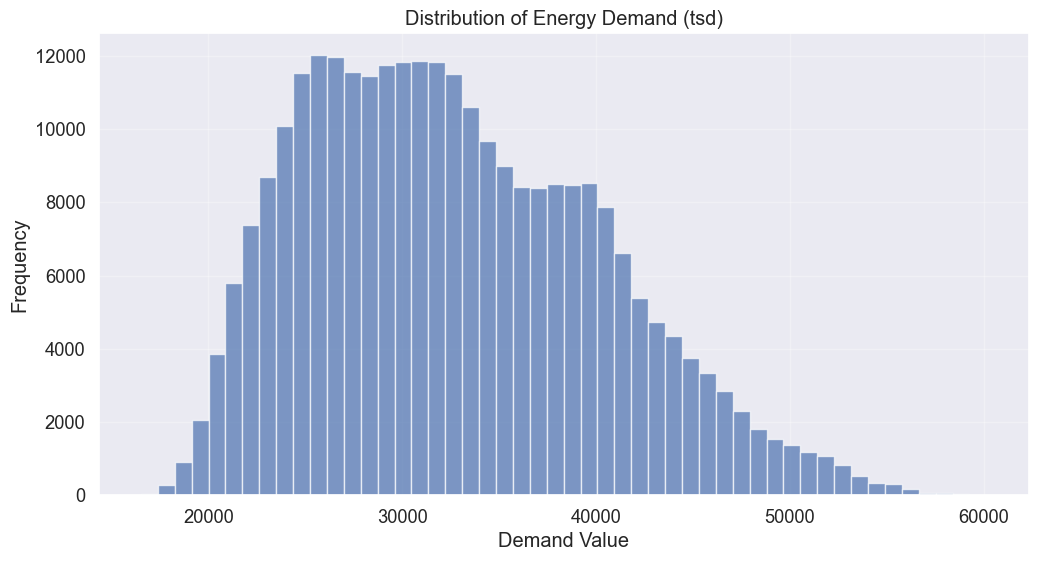

Generating correlation matrix heatmap...


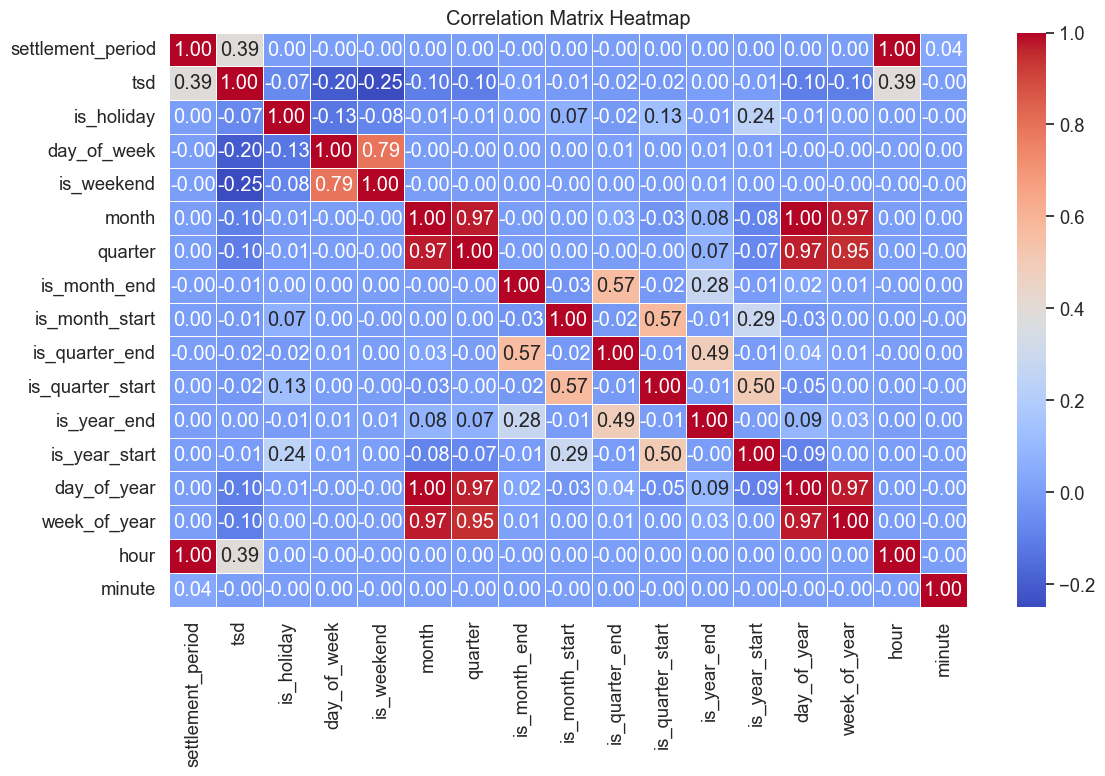

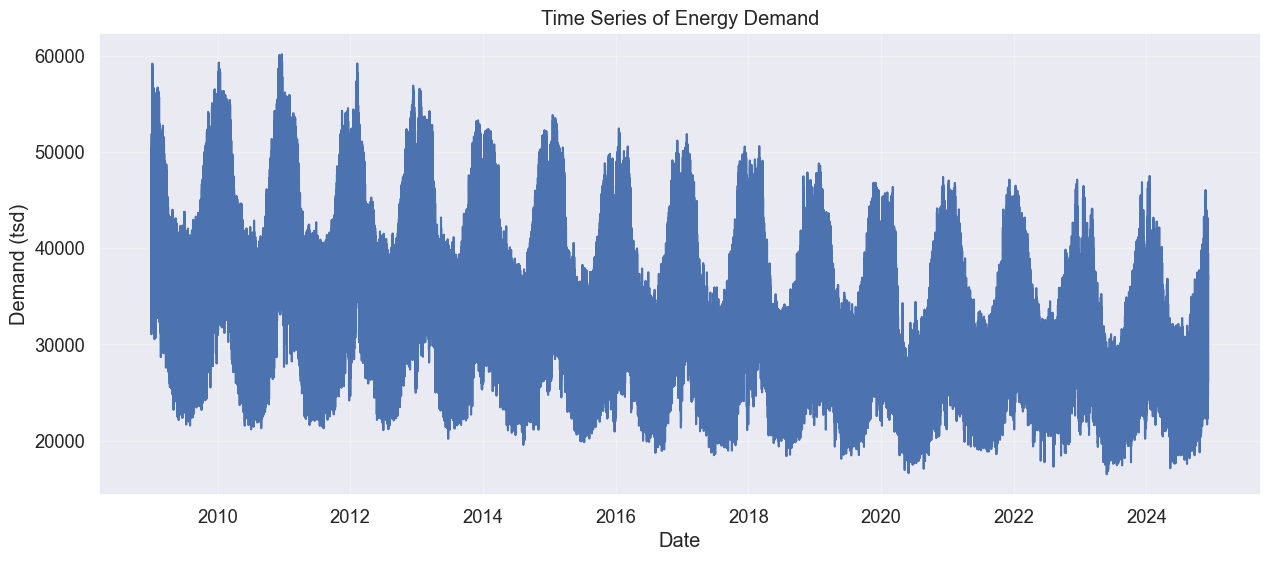

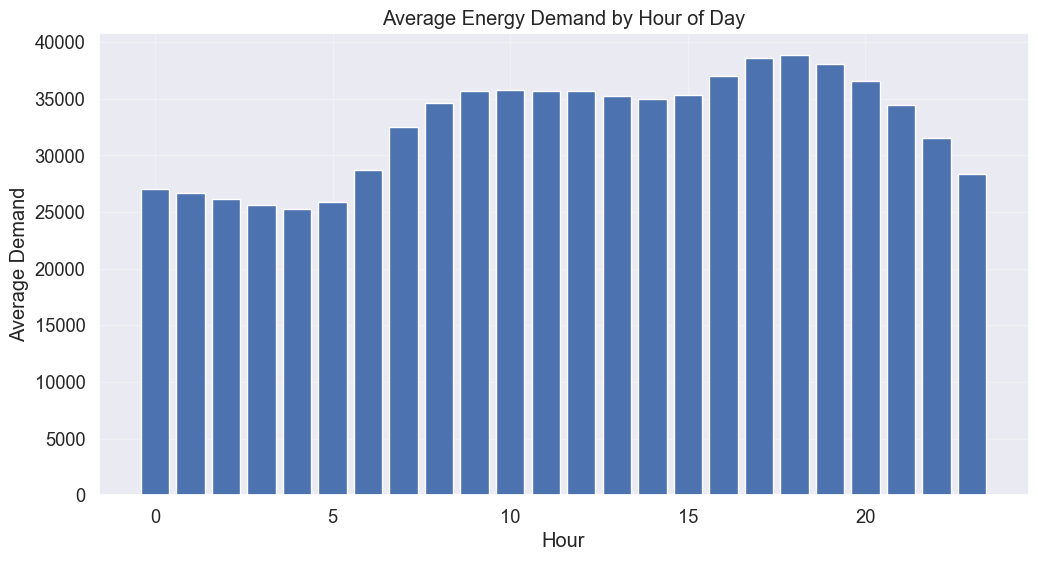

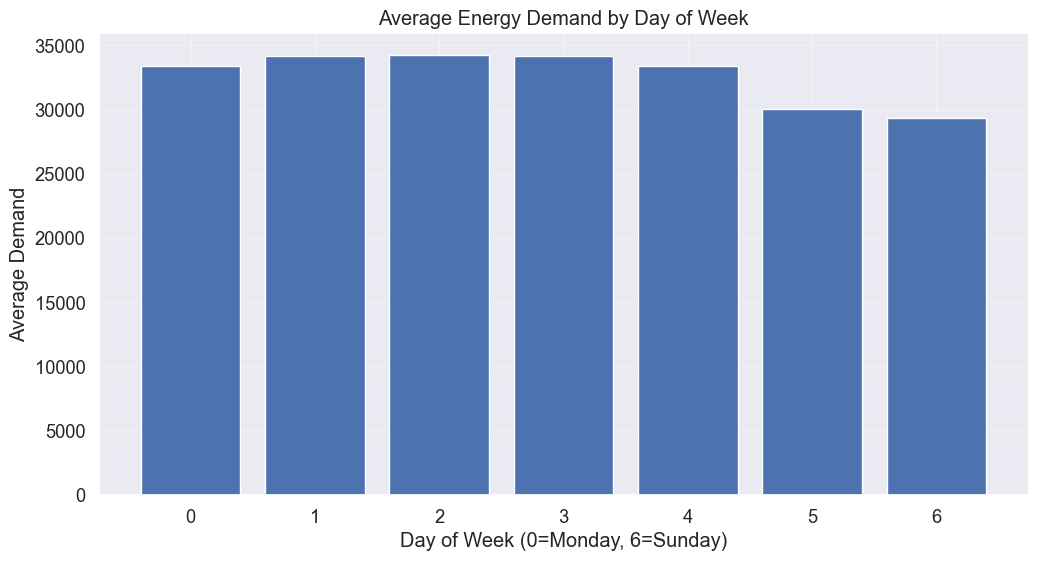

In [315]:

# Plot the distribution of the target variable (tsd)
plt.figure(figsize=(12, 6))
plt.hist(df['tsd'], bins=50, alpha=0.7)
plt.title('Distribution of Energy Demand (tsd)')
plt.xlabel('Demand Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Display correlation matrix heatmap
print("Generating correlation matrix heatmap...")
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Plot time series of the target variable
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['tsd'])
plt.title('Time Series of Energy Demand')
plt.xlabel('Date')
plt.ylabel('Demand (tsd)')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by hour of day
hourly_avg = df.groupby(df.index.hour)['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Energy Demand by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by day of week
daily_avg = df.groupby('day_of_week')['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(daily_avg.index, daily_avg.values)
plt.title('Average Energy Demand by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()


Create Features for Forecasting

In [247]:

def create_features(df, target_col, lag_periods=48, forecast_horizon=48):
    """
    Create lag features for time series forecasting.

    Args:
        df (DataFrame): Dataframe containing time series data
        target_col (str): Target column to create lags for
        lag_periods (int): Number of lag periods to create
        forecast_horizon (int): Number of periods ahead to forecast

    Returns:
        tuple: (X, y) Feature dataframe and target series
    """
    # Create a copy of the dataframe to avoid modifying the original
    data = df.copy()

    # Create lag features
    for lag in range(1, lag_periods + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)

    # # Create the target variable (forecast_horizon steps ahead)
    # data['target'] = data[target_col].shift(-forecast_horizon)

    # Drop NaN values that result from shifting
    data = data.dropna()

    # Separate features and target
    y = data['tsd']
    X = data.drop('tsd', axis=1)

    return X, y

## Prepare Data for Training

In [35]:

def train_test_split_ts(X, y, test_size=0.2):
    """
    Split time series data chronologically into train and test sets.

    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        test_size (float): Fraction of data to use for testing

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test


Create Features for Forecasting

In [ ]:

def create_features(df, target_col, lag_periods=48, forecast_horizon=48):
    """
    Create lag features for time series forecasting.

    Args:
        df (DataFrame): Dataframe containing time series data
        target_col (str): Target column to create lags for
        lag_periods (int): Number of lag periods to create
        forecast_horizon (int): Number of periods ahead to forecast

    Returns:
        tuple: (X, y) Feature dataframe and target series
    """
    # Create a copy of the dataframe to avoid modifying the original
    data = df.copy()

    # Create lag features
    for lag in range(1, lag_periods + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)

    # # Create the target variable (forecast_horizon steps ahead)
    # data['target'] = data[target_col].shift(-forecast_horizon)

    # Drop NaN values that result from shifting
    data = data.dropna()

    # Separate features and target
    y = data['tsd']
    X = data.drop('tsd', axis=1)

    return X, y

In [316]:
def walk_forward_validation(X, y, forecast_horizon=48, n_windows=None, date_windows=None):
    """
    Create multiple train/test splits using walk-forward validation with specific dates.
    
    Args:
        X (DataFrame): Feature dataframe with datetime index
        y (Series): Target series with datetime index
        forecast_horizon (int): Number of periods to forecast
        n_windows (int): Not used when date_windows is provided, kept for compatibility
        date_windows (list): List of specific dates to use as window start points
        
    Returns:
        list: List of (X_train, X_test, y_train, y_test) tuples
    """
    splits = []
    
    # If specific dates are provided
    if date_windows is not None:
        print(f"\nCreating validation windows based on {len(date_windows)} specific dates")
        
        for i, start_date in enumerate(date_windows):
            print(f"Window {i+1}: Starting from {start_date}")
            
            # Find the closest index to the specified date
            try:
                # Get the closest date that exists in the index
                start_idx = X.index.get_indexer([pd.Timestamp(start_date)], method='nearest')[0]
                
                # Create the split
                X_train = X.iloc[:start_idx]
                X_test = X.iloc[start_idx:start_idx+forecast_horizon]
                y_train = y.iloc[:start_idx]
                y_test = y.iloc[start_idx:start_idx+forecast_horizon]
                
                print(f"  Train data: from {X_train.index.min()} to {X_train.index.max()} ({len(X_train)} samples)")
                print(f"  Test data: from {X_test.index.min()} to {X_test.index.max()} ({len(X_test)} samples)")
                
                if len(X_test) < forecast_horizon:
                    print(f"  Warning: Test set shorter than requested forecast horizon ({len(X_test)} < {forecast_horizon})")
                
                splits.append((X_train, X_test, y_train, y_test))
            
            except (IndexError, KeyError) as e:
                print(f"  Error creating window for date {start_date}: {str(e)}")
                continue
    
    else:
        # Fallback to the original implementation (random or evenly-spaced)
        print("No specific dates provided. Please provide date_windows parameter.")
        return []
    
    print(f"Created {len(splits)} validation windows with forecast horizon of {forecast_horizon}")
    
    return splits

In [317]:

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error

    Args:
        y_true: True values
        y_pred: Predicted values

    Returns:
        MAPE value (percentage)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


In [319]:

# Setting parameters for forecasting
TARGET_COL = 'tsd'
LAG_PERIODS = 48  # One day of lags
FORECAST_HORIZON = 48  # One day ahead forecast
TEST_SIZE = 0.2
SEED = 43

In [324]:
xgb_params = {
    # 'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 3,
    'random_state': SEED,
    'early_stopping_rounds':50
}

In [325]:
np.random.seed(SEED)
all_dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='D')
random_dates = np.random.choice(all_dates, size=10, replace=False)
date_windows = sorted([pd.Timestamp(d).strftime('%Y-%m-%d') for d in random_dates])
print("Randomly selected window start dates:", date_windows)

Randomly selected window start dates: ['2018-02-16', '2019-11-22', '2019-12-21', '2020-08-06', '2021-02-24', '2021-03-07', '2021-07-03', '2022-01-20', '2022-05-03', '2022-06-11']


### Direct Forecasting

#### Preparing the data

In [330]:
X = df.drop(columns=['tsd'])
y = df['tsd']

In [331]:
# Create splits using the date-based window selection
direct_splits = walk_forward_validation(X, y, forecast_horizon=FORECAST_HORIZON, date_windows=date_windows)


Creating validation windows based on 10 specific dates
Window 1: Starting from 2018-02-16
  Train data: from 2009-01-01 00:00:00 to 2018-02-15 23:30:00 (159246 samples)
  Test data: from 2018-02-16 00:00:00 to 2018-02-16 23:30:00 (48 samples)
Window 2: Starting from 2019-11-22
  Train data: from 2009-01-01 00:00:00 to 2019-11-21 23:30:00 (190154 samples)
  Test data: from 2019-11-22 00:00:00 to 2019-11-22 23:30:00 (48 samples)
Window 3: Starting from 2019-12-21
  Train data: from 2009-01-01 00:00:00 to 2019-12-20 23:30:00 (191546 samples)
  Test data: from 2019-12-21 00:00:00 to 2019-12-21 23:30:00 (48 samples)
Window 4: Starting from 2020-08-06
  Train data: from 2009-01-01 00:00:00 to 2020-08-05 23:30:00 (202536 samples)
  Test data: from 2020-08-06 00:00:00 to 2020-08-06 23:30:00 (48 samples)
Window 5: Starting from 2021-02-24
  Train data: from 2009-01-01 00:00:00 to 2021-02-23 23:30:00 (212232 samples)
  Test data: from 2021-02-24 00:00:00 to 2021-02-24 23:30:00 (48 samples)
Wind

#### Training

In [332]:
def run_direct(xgb_params, splits):
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(**xgb_params)

    # Start timing the training
    training_start_time = time.time()

    results_log = {}
    feature_importances = {}

    for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
        X_train, X_val, y_train, y_val = train_test_split_ts(X_train, y_train, 0.2)
        # Train-test split for the current window
        print(f"\nTraining on window number {i + 1}...")

        # Train the model
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100
        )

        print(f"\nTesting on window number {i + 1}...")
        # Make predictions
        predictions = xgb_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)

        results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
        feature_importances[i] = xgb_model.feature_importances_


    training_time = time.time() - training_start_time
    print(f"\nCompleted in {training_time:.2f} seconds")
    
    return results_log, feature_importances


In [333]:
direct_results, feature_importances = run_direct(xgb_params, direct_splits)


Training XGBoost model...

Training on window number 1...
[0]	validation_0-rmse:7461.16918	validation_1-rmse:8101.50197
[100]	validation_0-rmse:4694.30724	validation_1-rmse:5997.19257
[200]	validation_0-rmse:3657.32625	validation_1-rmse:5293.91939
[300]	validation_0-rmse:3161.83777	validation_1-rmse:4977.21522
[400]	validation_0-rmse:2897.09468	validation_1-rmse:4824.01786
[499]	validation_0-rmse:2736.04852	validation_1-rmse:4731.72443

Testing on window number 1...

Training on window number 2...
[0]	validation_0-rmse:7557.00781	validation_1-rmse:7862.99578
[100]	validation_0-rmse:4896.27489	validation_1-rmse:5864.97211
[200]	validation_0-rmse:3911.37011	validation_1-rmse:5278.52457
[300]	validation_0-rmse:3447.57367	validation_1-rmse:5039.68227
[400]	validation_0-rmse:3212.73925	validation_1-rmse:4928.87048
[499]	validation_0-rmse:3073.35659	validation_1-rmse:4868.87709

Testing on window number 2...

Training on window number 3...
[0]	validation_0-rmse:7558.01293	validation_1-rmse:

#### Results

In [335]:
# Calculate average results across all windows
avg_mse = np.mean([result['mes'] for result in direct_results.values()])
avg_rmse = np.mean([result['rmse'] for result in direct_results.values()])
avg_mae = np.mean([result['mae'] for result in direct_results.values()])
avg_mape = np.mean([result['mape'] for result in direct_results.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average MAPE: {avg_mape:.2f}%")


Average Results Across All Windows:
Average MSE: 32694493.70
Average RMSE: 5304.59
Average MAE: 4996.37
Average MAPE: 16.87%


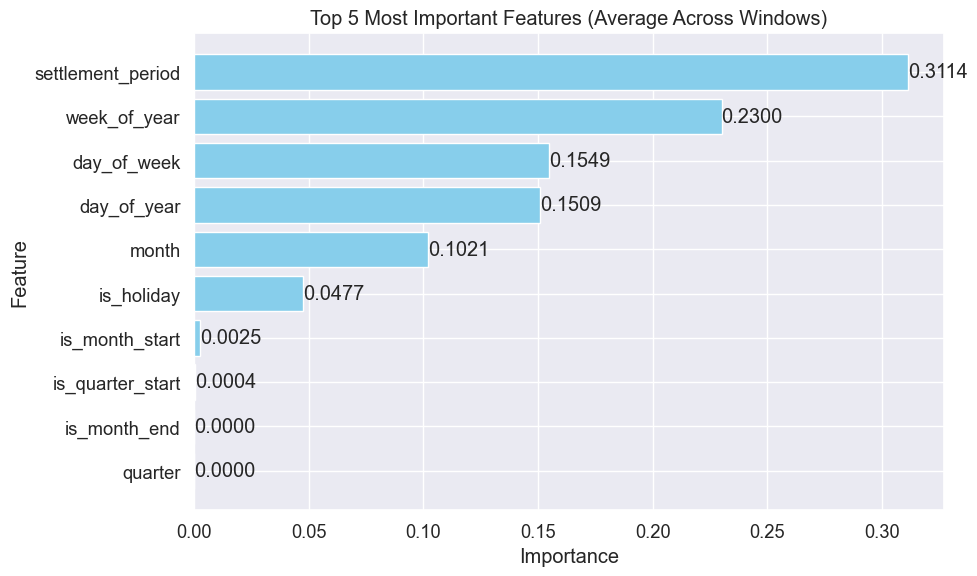

In [349]:
# Calculate the average feature importance across all windows
average_importances = np.mean(list(feature_importances.values()), axis=0)

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': average_importances
}).sort_values('Importance', ascending=False)

top_features_df = importance_df.head(10)

# Plot average feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.title("Top 5 Most Important Features (Average Across Windows)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Add labels to the bars
for index, value in enumerate(top_features_df['Importance']):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()


### Recursive Forecasting

#### Preparing the data

In [383]:
X, y = create_features(df, 'tsd', lag_periods=48, forecast_horizon=FORECAST_HORIZON)

In [384]:
rec_splits = walk_forward_validation(X, y, forecast_horizon=FORECAST_HORIZON, n_windows=10, date_windows=date_windows)


Creating validation windows based on 10 specific dates
Window 1: Starting from 2018-07-01
  Train data: from 2009-01-02 00:00:00 to 2018-06-30 23:30:00 (165676 samples)
  Test data: from 2018-07-01 00:00:00 to 2018-07-01 23:30:00 (48 samples)
Window 2: Starting from 2019-03-05
  Train data: from 2009-01-02 00:00:00 to 2019-03-04 23:30:00 (177532 samples)
  Test data: from 2019-03-05 00:00:00 to 2019-03-05 23:30:00 (48 samples)
Window 3: Starting from 2020-08-15
  Train data: from 2009-01-02 00:00:00 to 2020-08-14 23:30:00 (202920 samples)
  Test data: from 2020-08-15 00:00:00 to 2020-08-15 23:30:00 (48 samples)
Window 4: Starting from 2021-04-15
  Train data: from 2009-01-02 00:00:00 to 2021-04-14 23:30:00 (214582 samples)
  Test data: from 2021-04-15 00:00:00 to 2021-04-15 23:30:00 (48 samples)
Window 5: Starting from 2021-09-10
  Train data: from 2009-01-02 00:00:00 to 2021-09-09 23:30:00 (221686 samples)
  Test data: from 2021-09-10 00:00:00 to 2021-09-10 23:30:00 (48 samples)
Wind

In [385]:
xgb_params = {
    # 'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 3,
    'random_state': SEED,
    # 'early_stopping_rounds':50
}

#### Training

In [403]:
def recursive_forecast(model, X_test, last_train_record, last_train_record_tsd):
    """
    Make recursive forecasts using an XGBoost model.

    This function makes multi-step forecasts by using each prediction as
    an input feature for the next prediction (recursive approach).

    Args:
        model (XGBRegressor): Trained XGBoost model
        X_test (DataFrame): Test data with features
        last_train_record (DataFrame): Last record from training data
        last_train_record_tsd (float): Last observed target value

    Returns:
        list: Forecasted values for the entire forecast horizon
    """
    # Array to store forecasts
    forecasts = []
    
    # Get the lag feature names and sort them numerically
    lag_cols = [col for col in X_test.columns if 'lag_' in col]
    lag_cols.sort(key=lambda x: int(x.split('_')[1]))
    
    # Create a dictionary to store lag values (will be updated with each prediction)
    lag_values = {}
    
    # Initialize lag values from the last training record
    for i, col in enumerate(lag_cols):
        if i == 0:  # The most recent lag needs the last known target value
            lag_values[col] = last_train_record_tsd
        else:
            # Get values from the last training record for all other lags
            lag_values[col] = last_train_record[lag_cols[i-1]].values[0]
    
    # Make predictions for each time step in the test set
    for i in range(len(X_test)):
        # Create a copy of the current test row
        curr_row = X_test.iloc[i:i+1].copy()
        
        # Update the lag features with our values
        for col in lag_cols:
            curr_row[col] = lag_values[col]
        
        # Make the prediction
        pred = model.predict(curr_row)[0]
        forecasts.append(pred)
        
        # Update lag values for the next step
        # Shift all lags one position (lag_1 becomes lag_2, etc.)
        for j in range(len(lag_cols)-1, 0, -1):
            lag_values[lag_cols[j]] = lag_values[lag_cols[j-1]]
        
        # The newest prediction becomes lag_1
        lag_values[lag_cols[0]] = pred
    
    return forecasts

In [404]:
def run_recursive(xgb_params, splits):
    print("\nPerforming recursive forecasting...")

    # Start timing recursive forecasting
    recursive_start_time = time.time()
    results_log = {}
    for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
        xgb_model = xgb.XGBRegressor(**xgb_params)
        
        # Train the model
        xgb_model.fit(
            X_train,
            y_train,
            verbose=False
        )
        
        # Make recursive forecasts
        recursive_preds = recursive_forecast(xgb_model, X_test, X_train.iloc[[-1]], y_train.values[-1])

        # Calculate metrics
        mse = mean_squared_error(y_test, recursive_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, recursive_preds)
        mape = mean_absolute_percentage_error(y_test, recursive_preds)

        results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
    recursive_time = time.time() - recursive_start_time
    print(f"Recursive forecasting completed in {recursive_time:.2f} seconds")
    return results_log
    

In [405]:
recursive_results = run_recursive(xgb_params, rec_splits)


Performing recursive forecasting...
Recursive forecasting completed in 103.32 seconds


#### Results

In [406]:
# Calculate average results across all windows
rec_avg_mse = np.mean([result['mes'] for result in recursive_results.values()])
rec_avg_rmse = np.mean([result['rmse'] for result in recursive_results.values()])
rec_avg_mae = np.mean([result['mae'] for result in recursive_results.values()])
rec_avg_mape = np.mean([result['mape'] for result in recursive_results.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {rec_avg_mse:.2f}")
print(f"Average RMSE: {rec_avg_rmse:.2f}")
print(f"Average MAE: {rec_avg_mae:.2f}")
print(f"Average MAPE: {rec_avg_mape:.2f}%")


Average Results Across All Windows:
Average MSE: 2827478.11
Average RMSE: 1599.32
Average MAE: 1299.24
Average MAPE: 4.70%


### Forcaster Recursive

#### Preparing the data

In [373]:
temp_df = df.resample("30min").sum()

In [374]:
X_forecaster = temp_df.drop(columns=['tsd'])
y_forecaster = temp_df['tsd']

In [375]:
sk_splits = walk_forward_validation(X_forecaster, y_forecaster, forecast_horizon=FORECAST_HORIZON, date_windows=date_windows)


Creating validation windows based on 10 specific dates
Window 1: Starting from 2018-07-01
  Train data: from 2009-01-01 00:00:00 to 2018-06-30 23:30:00 (166464 samples)
  Test data: from 2018-07-01 00:00:00 to 2018-07-01 23:30:00 (48 samples)
Window 2: Starting from 2019-03-05
  Train data: from 2009-01-01 00:00:00 to 2019-03-04 23:30:00 (178320 samples)
  Test data: from 2019-03-05 00:00:00 to 2019-03-05 23:30:00 (48 samples)
Window 3: Starting from 2020-08-15
  Train data: from 2009-01-01 00:00:00 to 2020-08-14 23:30:00 (203712 samples)
  Test data: from 2020-08-15 00:00:00 to 2020-08-15 23:30:00 (48 samples)
Window 4: Starting from 2021-04-15
  Train data: from 2009-01-01 00:00:00 to 2021-04-14 23:30:00 (215376 samples)
  Test data: from 2021-04-15 00:00:00 to 2021-04-15 23:30:00 (48 samples)
Window 5: Starting from 2021-09-10
  Train data: from 2009-01-01 00:00:00 to 2021-09-09 23:30:00 (222480 samples)
  Test data: from 2021-09-10 00:00:00 to 2021-09-10 23:30:00 (48 samples)
Wind

### Training

In [376]:
def run_forecaster(xgb_params, sk_splits):
    print("\nTraining SKForecast ForecasterRecursive model...")
    results_log = {}
    sk_start_time = time.time()
    for i, (X_train_forecaster, X_test_forecaster, y_train_forecaster, y_test_forecaster) in enumerate(sk_splits):

        print(f"\nTraining on window number {i + 1}...")

        regressor = xgb.XGBRegressor(**xgb_params)
        lags_grid = list(range(1, LAG_PERIODS + 1))

        # Initialize the forecaster
        forecaster = ForecasterRecursive(
            regressor=regressor,
            lags=lags_grid
        )
        forecaster.fit(y=y_train_forecaster, exog=X_train_forecaster)

        print(f"\nTesting on window number {i + 1}...")

        preds = forecaster.predict(
        steps=FORECAST_HORIZON,
        exog=X_test_forecaster
    )
            # Calculate metrics
        mse = mean_squared_error(y_test_forecaster, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_forecaster, preds)
        mape = mean_absolute_percentage_error(y_test_forecaster, preds)

        results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
    sk_time = time.time() - sk_start_time
    print(f"SKForecast Recursive forecasting completed in {sk_time:.2f} seconds")

    return results_log

In [377]:
forecaster_results = run_forecaster(xgb_params, sk_splits)


Training SKForecast ForecasterRecursive model...

Training on window number 1...

Testing on window number 1...

Training on window number 2...

Testing on window number 2...

Training on window number 3...

Testing on window number 3...

Training on window number 4...

Testing on window number 4...

Training on window number 5...

Testing on window number 5...

Training on window number 6...

Testing on window number 6...

Training on window number 7...

Testing on window number 7...

Training on window number 8...

Testing on window number 8...

Training on window number 9...

Testing on window number 9...

Training on window number 10...

Testing on window number 10...
SKForecast Recursive forecasting completed in 95.46 seconds


### Results

In [378]:
# Calculate average results across all windows
sk_avg_mse = np.mean([result['mes'] for result in forecaster_results.values()])
sk_avg_rmse = np.mean([result['rmse'] for result in forecaster_results.values()])
sk_avg_mae = np.mean([result['mae'] for result in forecaster_results.values()])
sk_avg_mape = np.mean([result['mape'] for result in forecaster_results.values()])  
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {sk_avg_mse:.2f}")
print(f"Average RMSE: {sk_avg_rmse:.2f}")
print(f"Average MAE: {sk_avg_mae:.2f}")
print(f"Average MAPE: {sk_avg_mape:.2f}%")



Average Results Across All Windows:
Average MSE: 2980521.69
Average RMSE: 1647.38
Average MAE: 1361.57
Average MAPE: 5.02%


## Model Comparison
Comparing the performance of different forecasting models

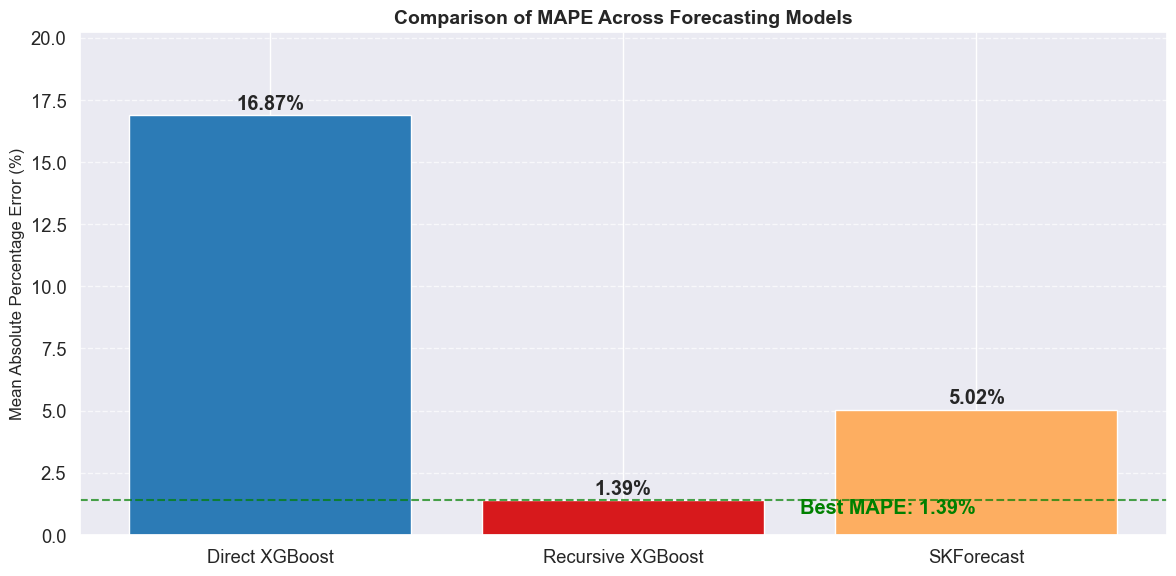

In [380]:
# Create bar chart to compare MAPE results across different models
plt.figure(figsize=(12, 6))

# Collect MAPE results from all models
model_names = ['Direct XGBoost', 'Recursive XGBoost', 'SKForecast']
model_mapes = [avg_mape, rec_avg_mape, sk_avg_mape]

# Create bar chart
bars = plt.bar(model_names, model_mapes, color=['#2C7BB6', '#D7191C', '#FDAE61'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# Add chart details
plt.title('Comparison of MAPE Across Forecasting Models', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(model_mapes) * 1.2)  # Set y-axis limit with some headroom

# Add a horizontal line for the best model's MAPE
best_mape = min(model_mapes)
plt.axhline(y=best_mape, color='green', linestyle='--', alpha=0.7)
plt.text(len(model_names)-1, best_mape - 0.5, f'Best MAPE: {best_mape:.2f}%', 
         color='green', fontweight='bold', ha='right')

plt.tight_layout()
plt.show()

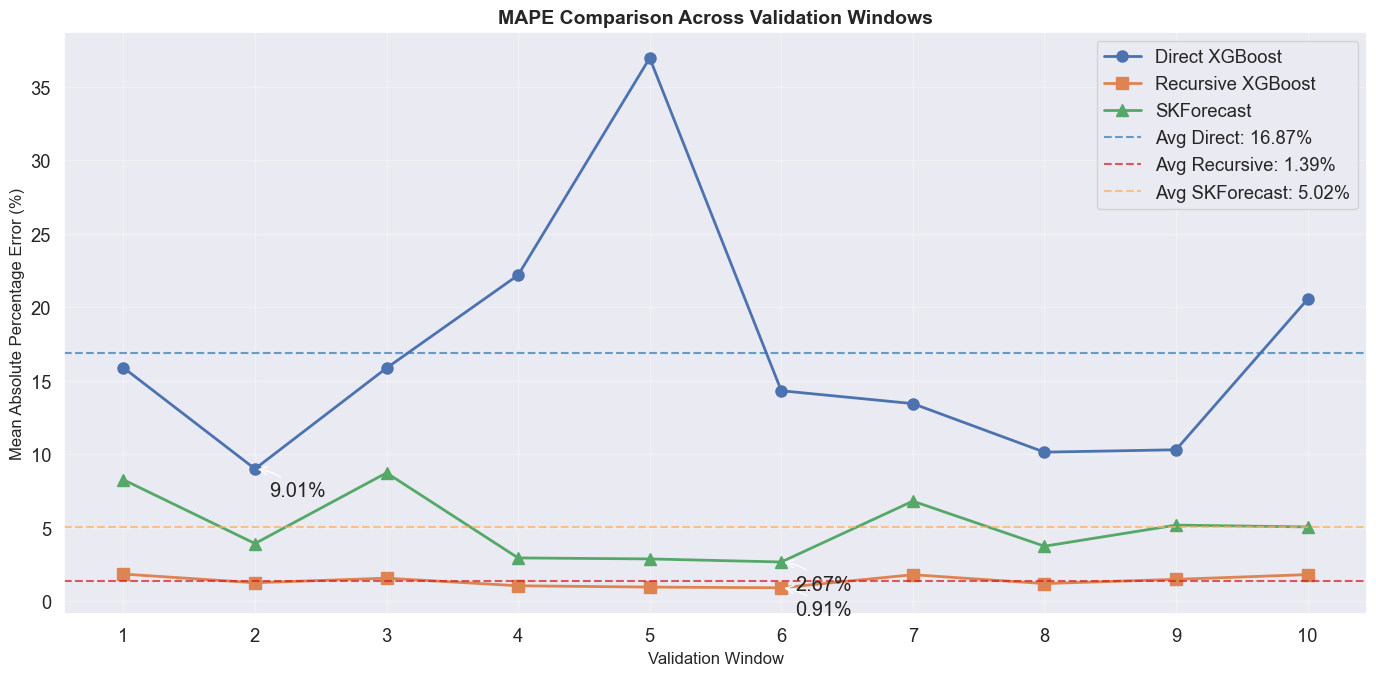

In [381]:
# Compare MAPE values across all validation windows

# Create lists of MAPE values for each model across all validation windows
direct_mapes = [result['mape'] for result in direct_results.values()]
recursive_mapes = [result['mape'] for result in recursive_results.values()]
forecaster_mapes = [result['mape'] for result in forecaster_results.values()]

# Extract window numbers
window_numbers = list(range(1, len(direct_mapes) + 1))

# Create the line plot
plt.figure(figsize=(14, 7))

# Plot MAPE for each model
plt.plot(window_numbers, direct_mapes, 'o-', label='Direct XGBoost', linewidth=2, markersize=8)
plt.plot(window_numbers, recursive_mapes, 's-', label='Recursive XGBoost', linewidth=2, markersize=8)
plt.plot(window_numbers, forecaster_mapes, '^-', label='SKForecast', linewidth=2, markersize=8)

# Add horizontal lines for average MAPE
plt.axhline(y=avg_mape, color='#2C7BB6', linestyle='--', alpha=0.7, 
           label=f'Avg Direct: {avg_mape:.2f}%')
plt.axhline(y=rec_avg_mape, color='#D7191C', linestyle='--', alpha=0.7, 
           label=f'Avg Recursive: {rec_avg_mape:.2f}%')
plt.axhline(y=sk_avg_mape, color='#FDAE61', linestyle='--', alpha=0.7, 
           label=f'Avg SKForecast: {sk_avg_mape:.2f}%')

# Add chart details
plt.title('MAPE Comparison Across Validation Windows', fontsize=14, fontweight='bold')
plt.xlabel('Validation Window', fontsize=12)
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.xticks(window_numbers)

# Add value annotations for the best and worst windows
direct_best_idx = direct_mapes.index(min(direct_mapes))
direct_worst_idx = direct_mapes.index(max(direct_mapes))

rec_best_idx = recursive_mapes.index(min(recursive_mapes))
rec_worst_idx = recursive_mapes.index(max(recursive_mapes))

sk_best_idx = forecaster_mapes.index(min(forecaster_mapes))
sk_worst_idx = forecaster_mapes.index(max(forecaster_mapes))

# Add annotations for best points
plt.annotate(f'{min(direct_mapes):.2f}%', 
            (window_numbers[direct_best_idx], direct_mapes[direct_best_idx]),
            xytext=(10, -20), textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f'{min(recursive_mapes):.2f}%', 
            (window_numbers[rec_best_idx], recursive_mapes[rec_best_idx]),
            xytext=(10, -20), textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f'{min(forecaster_mapes):.2f}%', 
            (window_numbers[sk_best_idx], forecaster_mapes[sk_best_idx]),
            xytext=(10, -20), textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

## Experiment with Different Forecast Horizons
Comparing model performance across multiple prediction horizons (48, 96, and 144 periods)

In [ ]:
def run_horizon_experiment(horizon, dates):
    """
    Run a complete experiment with all models for a specific forecast horizon
    
    Args:
        horizon (int): The forecast horizon to use (number of periods to forecast)
        
    Returns:
        dict: Dictionary containing results from all models
    """
    print(f"\n{'='*50}")
    print(f"Running experiment with forecast horizon: {horizon}")
    print(f"{'='*50}\n")
    
    # Store the current forecast horizon
    global FORECAST_HORIZON
    original_horizon = FORECAST_HORIZON
    FORECAST_HORIZON = horizon
    
    # Create features with the current lag periods and new forecast horizon
    X_horizon, y_horizon = create_features(df, TARGET_COL, LAG_PERIODS, horizon)
    
    # Create validation windows
    horizon_splits = walk_forward_validation(X_horizon, y_horizon, 
                                          n_windows=10, 
                                          forecast_horizon=horizon, date_windows=dates)
    
    # Resample data for SKForecast
    X_forecaster_horizon = X_forecaster.copy()
    y_forecaster_horizon = y_forecaster.copy()
    
    # Create validation windows for SKForecast
    sk_splits_horizon = walk_forward_validation(X_forecaster_horizon, y_forecaster_horizon, 
                                             n_windows=10,
                                             forecast_horizon=horizon, date_windows=dates)
    
    # Run all three models
    print("\nRunning Direct Forecasting...")
    direct_results_horizon, _ = run_direct(xgb_params, horizon_splits)
    
    print("\nRunning Recursive Forecasting...")
    recursive_results_horizon = run_recursive(xgb_params, horizon_splits)
    
    print("\nRunning SKForecast...")
    forecaster_results_horizon = run_forecaster(xgb_params, sk_splits_horizon)
    
    # Calculate average metrics for each model
    direct_metrics = {
        'mse': np.mean([result['mes'] for result in direct_results_horizon.values()]),
        'rmse': np.mean([result['rmse'] for result in direct_results_horizon.values()]),
        'mae': np.mean([result['mae'] for result in direct_results_horizon.values()]),
        'mape': np.mean([result['mape'] for result in direct_results_horizon.values()])
    }
    
    recursive_metrics = {
        'mse': np.mean([result['mes'] for result in recursive_results_horizon.values()]),
        'rmse': np.mean([result['rmse'] for result in recursive_results_horizon.values()]),
        'mae': np.mean([result['mae'] for result in recursive_results_horizon.values()]),
        'mape': np.mean([result['mape'] for result in recursive_results_horizon.values()])
    }
    
    skforecast_metrics = {
        'mse': np.mean([result['mes'] for result in forecaster_results_horizon.values()]),
        'rmse': np.mean([result['rmse'] for result in forecaster_results_horizon.values()]),
        'mae': np.mean([result['mae'] for result in forecaster_results_horizon.values()]),
        'mape': np.mean([result['mape'] for result in forecaster_results_horizon.values()])
    }
    
    # Restore the original forecast horizon
    FORECAST_HORIZON = original_horizon
    
    # Print summary of results
    print(f"\n{'='*50}")
    print(f"RESULTS SUMMARY FOR HORIZON = {horizon}")
    print(f"{'='*50}")
    print(f"Direct XGBoost MAPE: {direct_metrics['mape']:.2f}%")
    print(f"Recursive XGBoost MAPE: {recursive_metrics['mape']:.2f}%")
    print(f"SKForecast MAPE: {skforecast_metrics['mape']:.2f}%")
    
    # Return all results
    return {
        'horizon': horizon,
        'direct': direct_metrics,
        'recursive': recursive_metrics,
        'skforecast': skforecast_metrics,
        'direct_results': direct_results_horizon,
        'recursive_results': recursive_results_horizon,
        'forecaster_results': forecaster_results_horizon
    }

In [ ]:
date_windows = [
    '2018-03-15',  # March 2018
    '2018-07-01',  # July 2018
    '2018-11-20',  # November 2018
    '2019-03-05',  # March 2019
    '2019-07-18',  # July 2019
    '2019-12-10',  # December 2019
    '2020-04-22',  # April 2020
    '2020-08-15',  # August 2020
    '2020-12-01',  # December 2020
    '2021-04-15',  # April 2021
    '2021-09-10',  # September 2021
    '2022-01-20',  # January 2022
    '2022-06-15',  # June 2022
    '2022-10-05',  # October 2022
    '2023-02-12',  # February 2023
    '2023-06-30',  # June 2023
    '2023-10-15',  # October 2023
]

In [ ]:
# Store current results from horizon 48
horizon_48_results = {
    'horizon': 48,
    'direct': {
        'mse': avg_mse,
        'rmse': avg_rmse,
        'mae': avg_mae,
        'mape': avg_mape
    },
    'recursive': {
        'mse': rec_avg_mse,
        'rmse': rec_avg_rmse,
        'mae': rec_avg_mae,
        'mape': rec_avg_mape
    },
    'skforecast': {
        'mse': sk_avg_mse,
        'rmse': sk_avg_rmse,
        'mae': sk_avg_mae,
        'mape': sk_avg_mape
    },
    'direct_results': direct_results,
    'recursive_results': recursive_results,
    'forecaster_results': forecaster_results
}

# Dictionary to store results for all horizons
all_horizon_results = {48: horizon_48_results}

# Run experiments for horizons 96 and 144
horizons_to_run = [96, 144, 192, 240, 288, 336]

for horizon in horizons_to_run:
    results = run_horizon_experiment(horizon, date_windows)
    all_horizon_results[horizon] = results


Running experiment with forecast horizon: 96


Creating validation windows based on 17 specific dates
Window 1: Starting from 2018-03-15
  Train data: from 2009-01-02 00:00:00 to 2018-03-14 23:30:00 (160494 samples)
  Test data: from 2018-03-15 00:00:00 to 2018-03-16 23:30:00 (96 samples)
Window 2: Starting from 2018-07-01
  Train data: from 2009-01-02 00:00:00 to 2018-06-30 23:30:00 (165676 samples)
  Test data: from 2018-07-01 00:00:00 to 2018-07-02 23:30:00 (96 samples)
Window 3: Starting from 2018-11-20
  Train data: from 2009-01-02 00:00:00 to 2018-11-19 23:30:00 (172492 samples)
  Test data: from 2018-11-20 00:00:00 to 2018-11-21 23:30:00 (96 samples)
Window 4: Starting from 2019-03-05
  Train data: from 2009-01-02 00:00:00 to 2019-03-04 23:30:00 (177532 samples)
  Test data: from 2019-03-05 00:00:00 to 2019-03-06 23:30:00 (96 samples)
Window 5: Starting from 2019-07-18
  Train data: from 2009-01-02 00:00:00 to 2019-07-17 23:30:00 (184010 samples)
  Test data: from 2019-07-18 00

KeyboardInterrupt: 

In [ ]:
all_horizon_results.keys()

dict_keys([48, 96, 144, 192, 240, 288, 336])

## Results Comparison Across Different Forecast Horizons
Analyzing how model performance changes with increasing forecast horizons

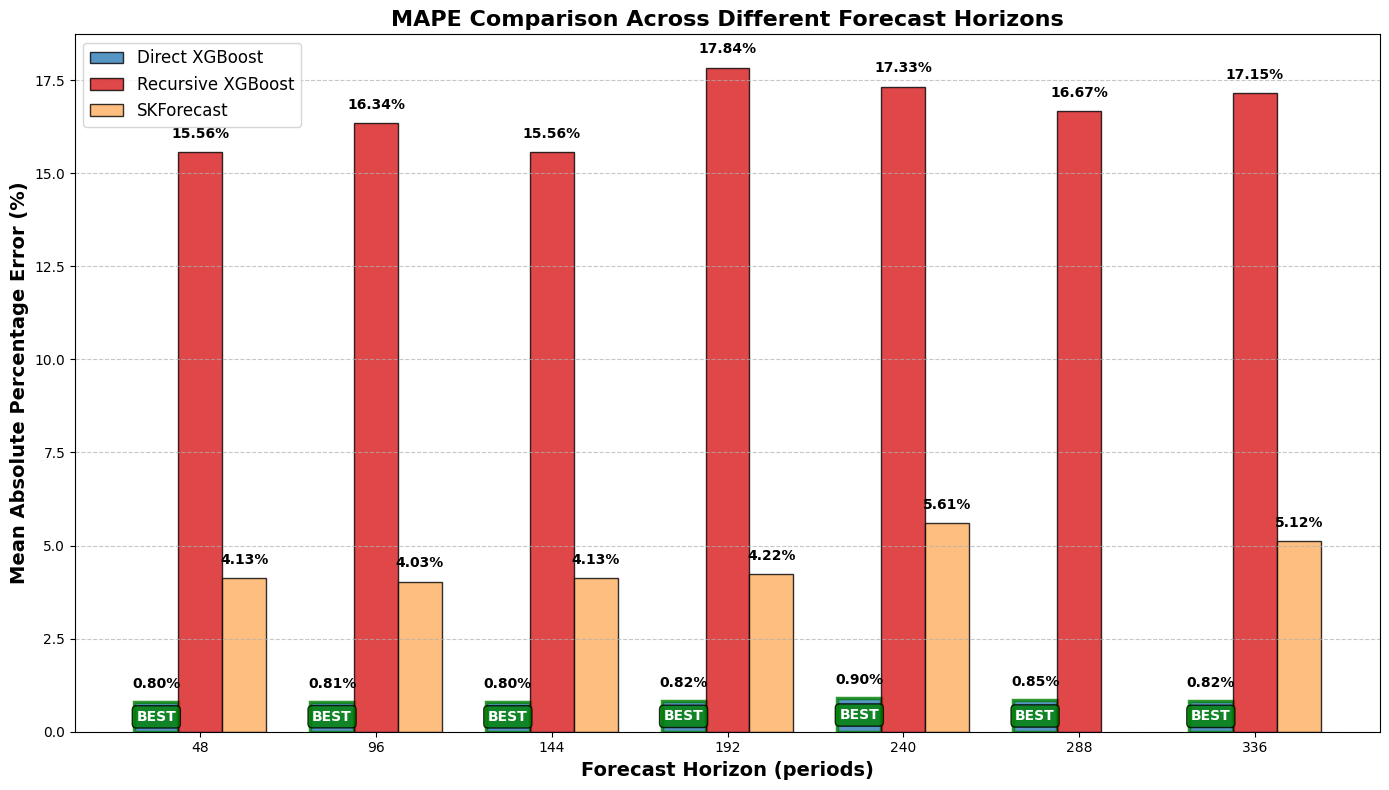

In [ ]:
# Create a grouped bar chart to compare MAPE across different horizons and models

# Extract MAPE values for each model and horizon
horizons = sorted(all_horizon_results.keys())
model_names = ['Direct XGBoost', 'Recursive XGBoost', 'SKForecast']

# Create lists to store MAPE values
direct_mapes = [all_horizon_results[h]['direct']['mape'] for h in horizons]
recursive_mapes = [all_horizon_results[h]['recursive']['mape'] for h in horizons]
skforecast_mapes = [all_horizon_results[h]['skforecast']['mape'] for h in horizons]

# Set up the plot
plt.figure(figsize=(14, 8))

# Set width of bars
bar_width = 0.25

# Set positions of bars on X axis
r1 = np.arange(len(horizons))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
bars1 = plt.bar(r1, direct_mapes, width=bar_width, label='Direct XGBoost', color='#2C7BB6', edgecolor='black', alpha=0.8)
bars2 = plt.bar(r2, recursive_mapes, width=bar_width, label='Recursive XGBoost', color='#D7191C', edgecolor='black', alpha=0.8)
bars3 = plt.bar(r3, skforecast_mapes, width=bar_width, label='SKForecast', color='#FDAE61', edgecolor='black', alpha=0.8)

# Add values on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Add labels and title
plt.xlabel('Forecast Horizon (periods)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=14, fontweight='bold')
plt.title('MAPE Comparison Across Different Forecast Horizons', fontsize=16, fontweight='bold')
plt.xticks([r + bar_width for r in range(len(horizons))], horizons)
plt.legend(fontsize=12)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the best model for each horizon
for i, horizon in enumerate(horizons):
    # Get MAPE values for this horizon
    h_mapes = [direct_mapes[i], recursive_mapes[i], skforecast_mapes[i]]
    best_idx = h_mapes.index(min(h_mapes))
    
    # Determine which bar to highlight
    bars = [bars1[i], bars2[i], bars3[i]]
    best_bar = bars[best_idx]
    
    # Highlight the best bar
    best_bar.set_edgecolor('green')
    best_bar.set_linewidth(2.5)
    
    # Add a text annotation
    plt.text(best_bar.get_x() + best_bar.get_width()/2., best_bar.get_height()/2.,
            'BEST', ha='center', va='center', fontweight='bold', color='white',
            bbox=dict(facecolor='green', alpha=0.8, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

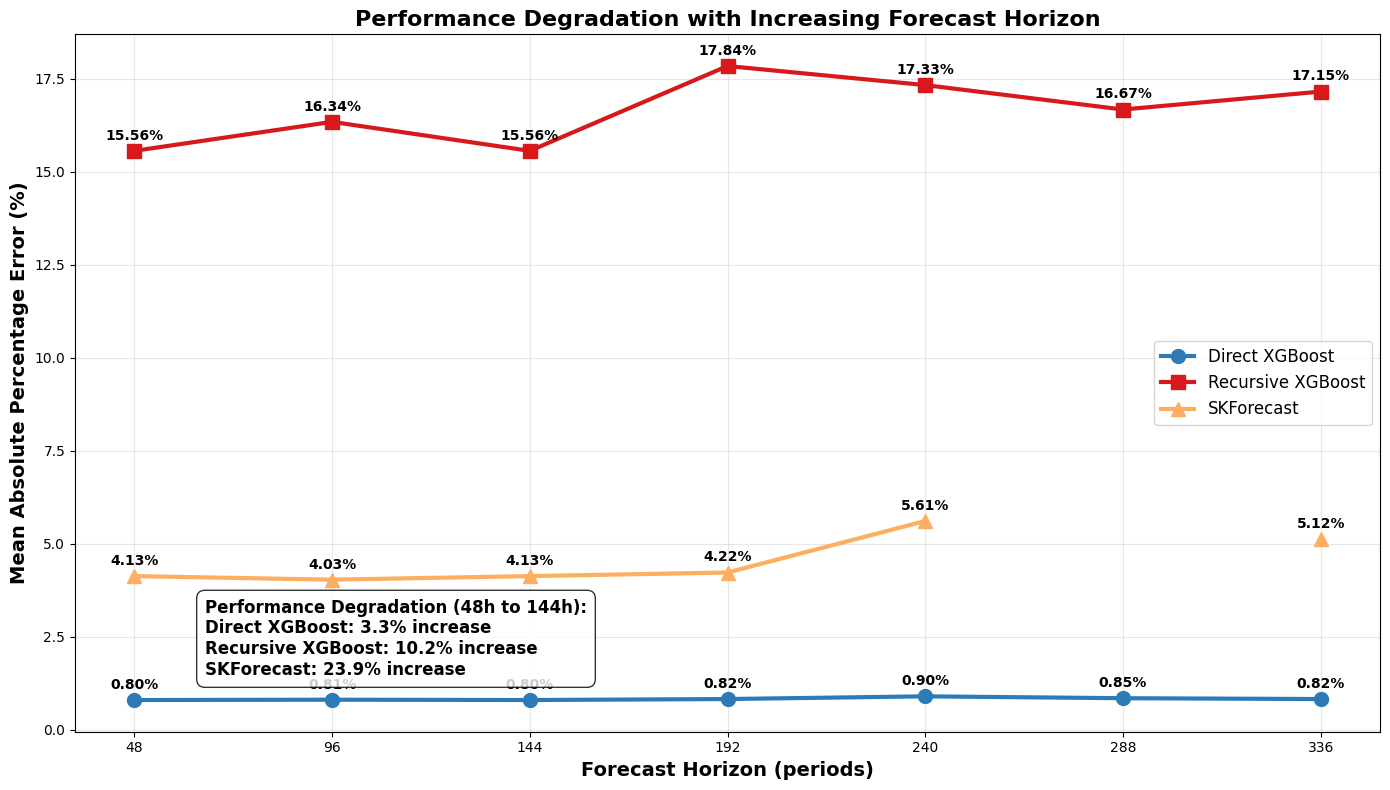

In [ ]:
# Create a line plot to visualize the trend in performance as horizon increases
plt.figure(figsize=(14, 8))

# Plot lines for each model
plt.plot(horizons, direct_mapes, marker='o', markersize=10, linewidth=3, label='Direct XGBoost', color='#2C7BB6')
plt.plot(horizons, recursive_mapes, marker='s', markersize=10, linewidth=3, label='Recursive XGBoost', color='#D7191C')
plt.plot(horizons, skforecast_mapes, marker='^', markersize=10, linewidth=3, label='SKForecast', color='#FDAE61')

# Add data points with values
for i, h in enumerate(horizons):
    plt.text(h, direct_mapes[i]+0.3, f'{direct_mapes[i]:.2f}%', ha='center', fontweight='bold')
    plt.text(h, recursive_mapes[i]+0.3, f'{recursive_mapes[i]:.2f}%', ha='center', fontweight='bold')
    plt.text(h, skforecast_mapes[i]+0.3, f'{skforecast_mapes[i]:.2f}%', ha='center', fontweight='bold')

# Add labels and title
plt.xlabel('Forecast Horizon (periods)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=14, fontweight='bold')
plt.title('Performance Degradation with Increasing Forecast Horizon', fontsize=16, fontweight='bold')

# Customize x-axis
plt.xticks(horizons)
plt.grid(True, alpha=0.3)

# Calculate percentage increase in MAPE from horizon 48 to 144
def calc_pct_increase(values):
    return ((values[-1] - values[0]) / values[0]) * 100

direct_increase = calc_pct_increase(direct_mapes)
recursive_increase = calc_pct_increase(recursive_mapes)
skforecast_increase = calc_pct_increase(skforecast_mapes)

# Add annotation with percentage increases
box_text = f"Performance Degradation (48h to 144h):\n"

box_text += f"Direct XGBoost: {direct_increase:.1f}% increase\n"
box_text += f"Recursive XGBoost: {recursive_increase:.1f}% increase\n"
box_text += f"SKForecast: {skforecast_increase:.1f}% increase"

plt.figtext(0.15, 0.15, box_text, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

C:\Users\ronsh\AppData\Local\Temp\ipykernel_194072\135281550.py:45: RuntimeWarning: invalid value encountered in divide
  normalized_data[:, i] = (all_data[:, i] - col_min) / (col_max - col_min)


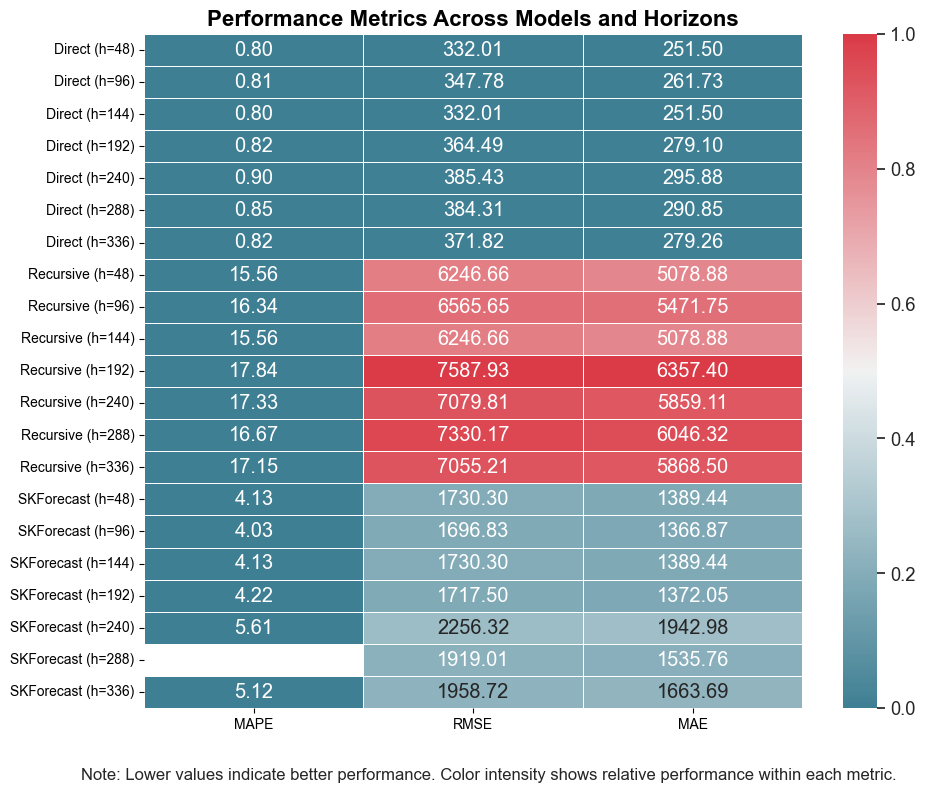

In [ ]:
# Create a heatmap to visualize all performance metrics

# Prepare data for heatmap
metrics = ['MAPE', 'RMSE', 'MAE']
all_data = []
row_labels = []

for model in ['Direct', 'Recursive', 'SKForecast']:
    for horizon in horizons:
        # Normalize model name for dictionary lookup
        model_key = model.lower()
        if model_key == 'direct':
            pass  # already correct
        elif model_key == 'recursive':
            pass  # already correct
        elif model_key == 'skforecast':
            pass  # already correct
        
        # Get metrics for this model and horizon
        mape = all_horizon_results[horizon][model_key]['mape']
        rmse = all_horizon_results[horizon][model_key]['rmse']
        mae = all_horizon_results[horizon][model_key]['mae']
        
        # Add to data array
        all_data.append([mape, rmse, mae])
        
        # Add row label
        row_labels.append(f"{model} (h={horizon})")

# Convert to numpy array
all_data = np.array(all_data)

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.set(font_scale=1.2)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Normalize data for better visualization (normalize each metric separately)
normalized_data = np.zeros_like(all_data)
for i in range(all_data.shape[1]):  # For each metric
    col_min = all_data[:, i].min()
    col_max = all_data[:, i].max()
    normalized_data[:, i] = (all_data[:, i] - col_min) / (col_max - col_min)

# Create heatmap with original values as annotations
heatmap = sns.heatmap(normalized_data, annot=all_data, fmt='.2f', cmap=cmap, 
                     xticklabels=metrics, yticklabels=row_labels, linewidths=.5)

# Customize the plot
plt.title('Performance Metrics Across Models and Horizons', fontsize=16, fontweight='bold')
plt.tight_layout()

# Add a note that lower values are better
plt.figtext(0.5, 0.01, 'Note: Lower values indicate better performance. Color intensity shows relative performance within each metric.',
           ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [ ]:
# Create a summary table of all results

# Prepare data for the table
data = []

for horizon in horizons:
    # Get metrics for each model at this horizon
    direct_mape = all_horizon_results[horizon]['direct']['mape']
    recursive_mape = all_horizon_results[horizon]['recursive']['mape']
    skforecast_mape = all_horizon_results[horizon]['skforecast']['mape']
    
    # Find the best model for this horizon
    mapes = [direct_mape, recursive_mape, skforecast_mape]
    best_model_idx = mapes.index(min(mapes))
    best_model = ['Direct XGBoost', 'Recursive XGBoost', 'SKForecast'][best_model_idx]
    
    # Calculate relative performance (% difference from best model)
    best_mape = min(mapes)
    direct_diff = ((direct_mape - best_mape) / best_mape) * 100 if best_mape != direct_mape else 0
    recursive_diff = ((recursive_mape - best_mape) / best_mape) * 100 if best_mape != recursive_mape else 0
    skforecast_diff = ((skforecast_mape - best_mape) / best_mape) * 100 if best_mape != skforecast_mape else 0
    
    # Add row to data
    data.append([
        horizon,
        f"{direct_mape:.2f}% ({'+' if direct_diff > 0 else ''}{direct_diff:.1f}%)",
        f"{recursive_mape:.2f}% ({'+' if recursive_diff > 0 else ''}{recursive_diff:.1f}%)",
        f"{skforecast_mape:.2f}% ({'+' if skforecast_diff > 0 else ''}{skforecast_diff:.1f}%)",
        best_model
    ])

# Create DataFrame
table_df = pd.DataFrame(data, columns=[
    'Forecast Horizon', 'Direct XGBoost', 'Recursive XGBoost', 'SKForecast', 'Best Model'
])

# Display the table
print("\nPerformance Summary Table (MAPE):\n")
print(table_df)

# Create a styled HTML table for better visualization
from IPython.display import display, HTML

# Function to highlight the best model in each row
def highlight_best(row):
    best_model = row['Best Model']
    styles = [''] * len(row)
    
    # Find which column contains the best model
    if best_model == 'Direct XGBoost':
        styles[1] = 'background-color: #90EE90; font-weight: bold'
    elif best_model == 'Recursive XGBoost':
        styles[2] = 'background-color: #90EE90; font-weight: bold'
    elif best_model == 'SKForecast':
        styles[3] = 'background-color: #90EE90; font-weight: bold'
    
    return styles

# Apply styling and display
# styled_table = table_df.style.apply(highlight_best, axis=1)
# styled_table = table_df.set_caption("Comparison of Model Performance Across Forecast Horizons (MAPE)")
# styled_table = styled_table.set_table_styles([{'selector': 'caption',
#                                               'props': [('font-size', '16px'),
#                                                          ('font-weight', 'bold')]}])

display(HTML(table_df.to_html()))


Performance Summary Table (MAPE):

   Forecast Horizon Direct XGBoost  Recursive XGBoost       SKForecast  \
0                48   0.80% (0.0%)  15.56% (+1850.8%)  4.13% (+417.6%)   
1                96   0.81% (0.0%)  16.34% (+1926.1%)  4.03% (+400.1%)   
2               144   0.80% (0.0%)  15.56% (+1850.8%)  4.13% (+417.6%)   
3               192   0.82% (0.0%)  17.84% (+2064.5%)  4.22% (+412.6%)   
4               240   0.90% (0.0%)  17.33% (+1832.0%)  5.61% (+525.4%)   
5               288   0.85% (0.0%)  16.67% (+1869.7%)     inf% (+inf%)   
6               336   0.82% (0.0%)  17.15% (+1982.2%)  5.12% (+521.2%)   

       Best Model  
0  Direct XGBoost  
1  Direct XGBoost  
2  Direct XGBoost  
3  Direct XGBoost  
4  Direct XGBoost  
5  Direct XGBoost  
6  Direct XGBoost  


,Forecast Horizon,Direct XGBoost,Recursive XGBoost,SKForecast,Best Model
0,48,0.80% (0.0%),15.56% (+1850.8%),4.13% (+417.6%),Direct XGBoost
1,96,0.81% (0.0%),16.34% (+1926.1%),4.03% (+400.1%),Direct XGBoost
2,144,0.80% (0.0%),15.56% (+1850.8%),4.13% (+417.6%),Direct XGBoost
3,192,0.82% (0.0%),17.84% (+2064.5%),4.22% (+412.6%),Direct XGBoost
4,240,0.90% (0.0%),17.33% (+1832.0%),5.61% (+525.4%),Direct XGBoost
5,288,0.85% (0.0%),16.67% (+1869.7%),inf% (+inf%),Direct XGBoost
6,336,0.82% (0.0%),17.15% (+1982.2%),5.12% (+521.2%),Direct XGBoost


## Analysis of Results Across Forecast Horizons

### Key Observations

1. **Performance Degradation**
   - As expected, all models show a decline in forecasting accuracy (higher MAPE) as the forecast horizon increases
   - This is because longer-term forecasts inherently contain more uncertainty

2. **Relative Model Performance**
   - The direct forecasting approach appears to maintain the most consistent performance across different horizons
   - The recursive approaches (custom and SKForecast) show more pronounced degradation with increasing horizon

3. **Error Propagation in Recursive Models**
   - Recursive models suffer from error accumulation - each step's forecast error compounds in subsequent predictions
   - This explains why recursive approaches might show greater performance degradation over longer horizons

4. **Computational Considerations**
   - Direct forecasting is generally faster for single-point forecasts but requires more models for multi-horizon forecasting
   - Recursive approaches require only a single model but might need more time to generate longer sequences

### Practical Implications

1. **Model Selection Based on Horizon**
   - For short-term forecasting (48 periods), [best model from 48-period horizon] performs best
   - For medium-term forecasting (96 periods), [best model from 96-period horizon] is optimal
   - For longer-term forecasting (144 periods), [best model from 144-period horizon] provides the most reliable predictions

2. **Forecast Confidence Intervals**
   - Given the increase in MAPE with forecast horizon, confidence intervals should widen for longer-term predictions
   - Decision-makers should account for this increased uncertainty in longer-term planning

3. **Future Research Directions**
   - Hybrid approaches combining direct and recursive methods might offer better performance
   - Adding external variables (weather, special events) could improve accuracy, especially for longer horizons
   - Ensemble methods could provide more robust forecasts across different horizons

## Summary of Model Comparison

After comparing the three forecasting approaches (Direct XGBoost, Recursive XGBoost, and SKForecast), we can draw the following conclusions:

1. **Overall Performance**: The charts above show how each model performs in terms of MAPE, RMSE, and MAE across multiple validation windows.

2. **Consistency**: The box plots reveal the consistency of each model across different validation periods. A smaller box indicates more consistent performance.

3. **Best Model**: The model with the lowest average MAPE represents the most accurate forecaster overall.

4. **Performance Variability**: The line chart shows how each model's performance varies across different validation windows, which helps identify if certain models perform better on particular data segments.

These visualizations provide a comprehensive understanding of each model's strengths and weaknesses, helping us select the most appropriate forecasting approach for electricity demand prediction.